# 5.2ノイズフィルター

この節未完成


## この節について

この節では、ノイズフィルターについて解説します。

この節のの内容はColabノートブックとして公開してあります。ノートブックを見るには[目次ページ](https://colab.research.google.com/github/moizumi99/camera_raw_processing/blob/master/camera_raw_toc.ipynb)から参照するか、以下のリンクを使ってアクセスしてください。

https://colab.research.google.com/github/moizumi99/camera_raw_processing/blob/master/camera_raw_chapter_5_2.ipynb

## 準備

まずライブラリーのインストールと、モジュールのインポート、画像の読み込みを行います。今回もラズベリーパイで撮影したチャート画像を使用します。
内容については各節を参照ください。

In [1]:
# rawpyとimageioのインストール
!pip install rawpy;
!pip install imageio;

# rawpy, imageio, numpuy, pyplot, imshowのインポート
import rawpy, imageio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# 前節までに作成したモジュールのダウンロードとインポート
!if [ ! -f raw_process.py ]; wget https://github.com/moizumi99/camera_raw_processing/raw/master/raw_process.py; fi
from raw_process import simple_demosaic, white_balance, black_level_correction, gamma_correction
from raw_process import demosaic, defect_correction, color_correction_matrix, lens_shading_correction

# 日本語フォントの設定
!apt -y install fonts-ipafont-gothic
plt.rcParams['font.family'] = 'IPAPGothic'
# もし日本語が文字化けしている場合`! rm /content/.cache/matplotlib/fontList.json`を実行して、
# Runtime->Restart Runtimeで再実行

# 画像をダウンロードします。
!if [ ! -f chart.jpg ]; then wget https://github.com/moizumi99/camera_raw_processing/raw/master/chart.jpg; fi

# 自分で撮影した画像を使用する場合は以下のコメントを取り除きアップロードします。
# from google.colab import files
# uploaded = files.upload()

# RAWファイルの名前。
# アップロードしたファイルを使う場合はその名前に変更。
raw_file  = "chart.jpg"
raw = rawpy.imread(raw_file)
raw_array = raw.raw_image
h, w = raw_array.shape

/bin/sh: 1: Syntax error: "fi" unexpected (expecting "then")
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


## デジタル画像のノイズ

デジタル画像にも当然ながらノイズはあります。

ノイズ源には様々な物がありますが、ごくごく大雑把に言うと、センサーから画像データを読み出す際に付加されるリードノイズと、センサーの各セルに入ってくる光の量の統計的ゆらぎによる光ショットノイズが大きな要因になります。

もちろんこれは非常に__大雑把__な分類で、リードノイズには、熱ショットノイズ、固定パターンノイズ、暗電流、などがあります。

光ショットノイズは光の量に依存して、その分散は次のようなポアッソン分布を取る事が知られています。

$$ \sigma^{2} \left( n \right) = n $$

本来、光ショットノイズは光の量のみに依存するノイズのはずですが、実在する画像センサーの特性が理想的なものとは異なるために（非線形性やクロストークなど）、実際の観測では複雑な特性を見せたりします。

結局、ノイズ量も実際のセンサーやカメラ系で測定してカリブレーションする事になります。

最近のカメラ画像処理では、こういったカリブレーションによるノイズ量の推定はノイズモデルと呼ばれ重要視されています。

## 実際の画像のノイズ

それでは前章で処理した画像のノイズを観察してみましょう。

まずはRAW現像します。

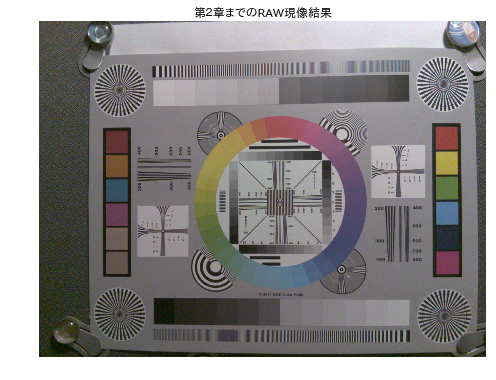

In [113]:
blc_raw = black_level_correction(raw_array, raw.black_level_per_channel, raw.raw_pattern)
lsc = [np.array([6.07106808e-07, 9.60556906e-01]), 
       np.array([6.32044369e-07, 9.70694361e-01]), 
       np.array([6.28455183e-07, 9.72493898e-01]), 
       np.array([9.58743579e-07, 9.29427169e-01])]
lsc_raw = lens_shading_correction(blc_raw, lsc)
dpc_raw = defect_correction(lsc_raw, 16)
wb_raw = white_balance(dpc_raw, raw.camera_whitebalance, raw.raw_colors)
dms_img = demosaic(wb_raw, raw.raw_colors)
color_matrix = np.array([6022,-2314,394,-936,4728,310,300,-4324,8126])/4096
ccm_img = color_correction_matrix(dms_img, color_matrix)
white_level = 1024
gmm_img = gamma_correction(ccm_img / white_level, 2.2)

# 画像表示
plt.figure(figsize=(8, 8))
plt.imshow(gmm_img)
plt.axis('off')
plt.title(u"第２章までのRAW現像結果")
plt.show()

この画像を拡大すると、このようになっています。

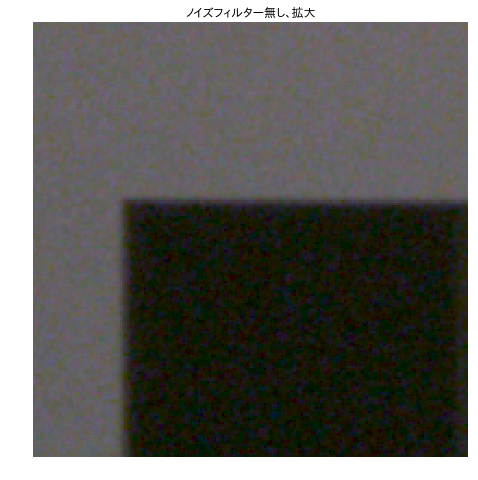

In [114]:
# 画像表示
plt.figure(figsize=(8, 8))
plt.imshow(gmm_img[1950:2150, 800:1000, :])
plt.axis('off')
plt.title(u"ノイズフィルター無し、拡大")
plt.show()

なんだかざらざらしていますし、本来グレーや黒の部分に色が浮かんでいます。なるべく明るくして撮影したのですが、まだだいぶノイズがのっているようです。

では実際どの程度の量のノイズがあるのか測定してみましょう。

![ノイズ測定領域](https://github.com/moizumi99/camera_raw_processing/raw/master/fig_5_2_1.png)

図のグレイパッチ部分（赤い長方形で囲った部分）のノイズ量を実際に測定してみます。

各グレイパッチの座標を画像ビューワーなどで調べ、測定領域を決めておきます。

今回は次のような座標をとり、その点から右下の100x100画素の正方形の領域を測定します。

In [25]:
patches = [(2586, 2086), (2430, 2092), (2272, 2090), (2112, 2090), (1958, 2086), (1792, 2094), 
           (1642, 2096), (1486, 2090), (1328, 2090), (1172, 2086), (1016,2084), (860, 2084),
           (866, 482), (1022, 480), (1172, 476), (1328, 474), (1480, 470), (1634, 466),
          (1788, 462), (1944, 460), (2110, 452), (2266, 452), (2424, 448), (2586, 442)]

各パッチ内の画素の分散と平均値を測定してみます。
画像のフォーマットがBayerなので、各色チャンネル毎に統計をとります。

測定結果を見てみましょう。

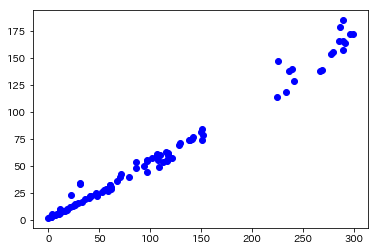

In [27]:
plt.plot(averages, variances, linestyle='None', marker='o', color='blue')
plt.show()

どうやら、分散は画素の値に対してほぼ線形になっているようです。光ポワッソンノイズが支配的だと予想されます。

一次多項式で近似してみましょう。

In [28]:
par = np.polyfit(averages, variances, 1)
print(par)

[ 0.56326801 -1.1732412 ]


では、近似した１次式ともとのグラフを並べてみましょう。

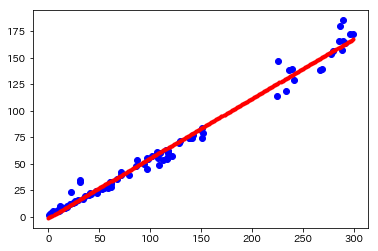

In [33]:
xs = np.arange(0, 300, 1)
ys = par[1] + par[0] * xs
plt.plot(averages, variances, linestyle='None', marker='o', color='blue')
plt.plot(xs, ys, linestyle='None', marker='.', color='red')
plt.show()

ほぼ近似できているようです。

## ノイズフィルターの定番バイラテラルフィルター

ノイズフィルターに求められる特性として、ノイズは取り除いてほしいが、元の画像に含まれる情報は残しておきたい、というものがあります。

このような矛盾する要求に答えるものとしてバイラテラルフィルター[^1]があります。

[^1]: Bilateral Filtering for Gray and Color Images, C. Tomasi and R. Manduchi, Proceedings of the 1998 IEEE International Conference on Computer Vision,  pp. 839–846, 1998

バイラテラルフィルターのアイデアは基本的に、

1.  ある画素の周辺の画素のうち、値が近いものは同じものだからフィルターをかける
2. 値が遠いものは違うものだからフィルターをかけない。

というものです。

たとえば、各ターゲット画素のまわりに次のような5x5の領域を設定します。

![注目した画素の周辺](https://github.com/moizumi99/camera_raw_processing/raw/master/fig_5_2_2.png)

赤で囲った画素がターゲットです。

周りの画素のうち、灰色の画素はターゲットに近い値を持ち、黒い画素は大きく異なる値を持つとします。

この場合、灰色の部分は画像のある部分（たとえば新聞の地の部分）、黒い部分は他の部分（たとえば新聞の印刷部分）に含まれると考えられます。

そうなると、灰色の画素にのみフィルターをかけ、黒い画素にはフィルターをかけないことで、画像の特徴に影響を与えずにノイズフィルターをかける事ができます。

一例としてはこのようなフィルターになるでしょう。（これは説明用の図で、実際のフィルターとは異なります。）

![フィルターの値](https://github.com/moizumi99/camera_raw_processing/raw/master/fig_5_2_3.png)

バイラテラルフィルターでは、ターゲット画素と周辺画素の一つ一つの値の差を取り、それをノイズの量とくらべて加重平均のウェイトを計算することで、ターゲット画素に近いものにのみフィルターを適用します。

式としては、例えばこうなります。

$$
p\_{\rm{out}} \left( x, y \right) = 
\frac{\sum_{dy=-N}^{+N} \sum_{dx=-N}^{+N}  w \left( dx, dy \right) p\_{\rm{in}} \left( x + dx, y + dy \right)}
{\sum_{dy=-N}^{+N} \sum_{dx=-N}^{+N}  w \left( dx, dy \right)}
$$

$$
w \left( dx, dy \right) = exp \left( - \frac { a |p\_{\rm{in}} \left(x + dx, y + dy \right) - p\_{\rm{in}} \left( x, y \right) |^{2} + b | dx^{2} + dy^{2} |} {\sigma^{2}} \right)
$$

ただし、$p\_{\rm{in}}$が入力画像で、$p\_{\rm{out}}$が出力画像、$\left(x, y \right)$が座標です。$N$はウィンドウのサイズ、$a$はチューニングパラメータで0以上（通常1以下）です。

この式によって、ターゲット画素と周辺画素は$w$の計算の中で比べられます。差が$\sigma$に比べて大きければ$w$は小さくなり、その画素のウェイトは小さくなります。
逆にターゲットの差が小さい場合は$w$の値は１に近くなり、大きなウェイトを持つことになります。

もし周辺の画像が全てターゲット画像に近い場合、フィルターの形はガウシアンフィルターに近づいていきます。

一つ注意として、ノイズ分散の扱いがあります。
通常の画像処理の教科書ではノイズ分散は画像内で一定という仮定を行います。
もしリード・ノイズが支配的ならこの仮定は正しいのですが、先程見たとおり実際の画像ではショットノイズのためにノイズの分散は画素の値に依存します。

もしノイズフィルターをかけるのがカメラ画像処理後のRGBやYUVの画像だとすると、すでにガンマ補正やローカルトーンマップ補正などの処理が行われていて、元のノイズの分布を推定するのは困難です。
RAW画像から処理する場合はこのような処理が行われていないことはわかっているので、ショットノイズなどのノイズ量を推定するのは簡単です。

次は測定したノイズの特性を利用してノイズ処理を行っていきます。

## バイラテラルノイズフィルターの適用

ではこのノイズフィルターを実際の画像に適用してみましょう。

Bayerフォーマットのままではフィルターがかけにくいので、デモザイク後の値を使用します。一応この段階の画像を確認しておきましょう。

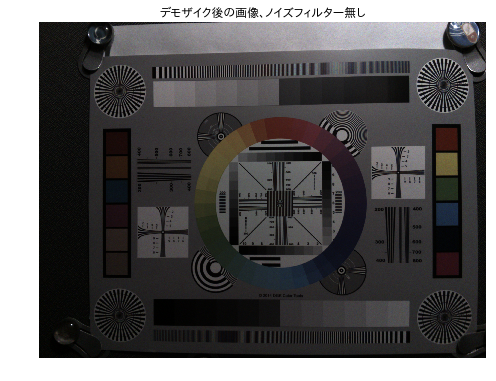

In [37]:
outimg = dms_img / 1024
outimg[outimg < 0] = 0
outimg[outimg > 1] = 1
plt.figure(figsize=(8, 8))
plt.imshow(outimg)
plt.axis('off')
plt.title(u"デモザイク後の画像、ノイズフィルター無し")
plt.show()

さて、ホワイトバランスやデモザイク処理を行った後でも、ノイズの分散は画素の値に比例するのでしょうか？
RGBの平均に対して確かめてみましょう。

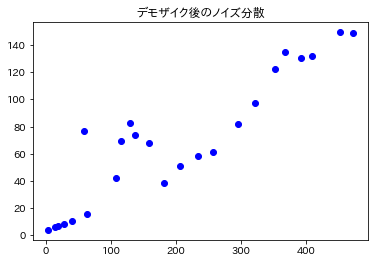

In [43]:
luma_img = dms_img.mean(2)
variances = []
averages = []
for patch in patches:
    x, y = patch
    p = luma_img[y:y+100, x:x+100]
    s2 = (p * p).mean()
    av = p.mean()
    v = s2 - av * av
    variances.append(v)
    averages.append(av)

plt.plot(averages, variances, linestyle='None', marker='o', color='blue')
plt.title(u"デモザイク後のノイズ分散")
plt.show()

先ほどとは多少様子が違いますが、線形近似で大丈夫そうです。

傾きを求めて確かめてみましょう。

傾き 0.29300604909937544


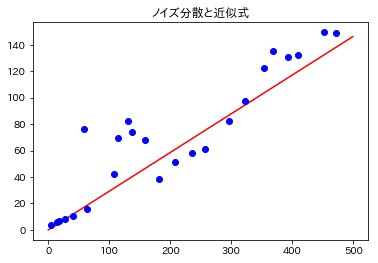

In [84]:
par = np.polyfit(averages, variances, 1)
print(u'傾き', par[0])

xs = np.arange(0, 500)
ys = par[0] * xs
plt.plot(xs, ys, color='red')
plt.plot(averages, variances, linestyle='None', marker='o', color='blue')
plt.title('ノイズ分散と近似式')
plt.show()

Bayerでの測定に比べると誤差が大きいようですが、この程度のずれなら使えそうです。

さあ、これでノイズフィルターを適用する準備ができました。実際にかけてみましょう。
今回はフルカラーなので、ウェイトの計算はRGBの平均に対して行い、フィルターの適用は各カラーごとに行うという方法を使っています。
コード中、coefがバイラテラルフィルターの式の$a$に相当します。なお今回は$b = 0$としました。

In [57]:
# 注：これは処理をわかりやすく書いたもので非常に実行速度が遅い。
# 実際にはこの後の高速版を使用することをおすすめする
import math

coef = 0.1
img_flt = dms_img.copy()
for y in range(2, h-2):
    for x in range (2, w - 2):
        # 5x5の平均値からノイズの分散(sigma) を推定する
        average = luma_img[y-2:y+3, x-2:x+3].mean()
        sigma = par[0] * average
        sigma = sigma if sigma > 0 else 1

        weight = np.zeros((5, 5))
        out_pixel = np.zeros(3)
        norm = 0
        # 5x5内の各画素毎に重みを計算する
        for dy in range(-2, 3):
            for dx in range(-2, 3):
                # 中心画素との差
                diff = luma_img[y + dy, x + dx] - luma_img[y, x]
                diff_norm = diff * diff / sigma
                # 差と分散からウェイトを計算し、加重平均値を求める
                weight = math.exp(-coef * diff_norm)
                out_pixel += weight * dms_img[y + dy, x + dx, :]
                norm += weight
        # 各色毎にウェイトの和で正規化する
        img_flt[y, x, 0] = out_pixel[0] / norm
        img_flt[y, x, 1] = out_pixel[1] / norm
        img_flt[y, x, 2] = out_pixel[2] / norm

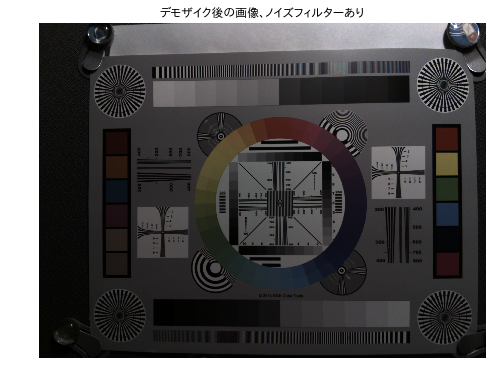

In [80]:
img_flt = noise_filter(dms_img, 0.1, 0, 0.3)
outimg = img_flt.copy()
outimg = outimg / 1024
outimg[outimg < 0] = 0
outimg[outimg > 1] = 1
plt.figure(figsize=(8, 8))
plt.imshow(outimg)
plt.axis('off')
plt.title(u"デモザイク後の画像、ノイズフィルターあり")
plt.show()

このままではわかりにくいので、残りの処理（カラーマトリクスとガンマ補正）を行います。

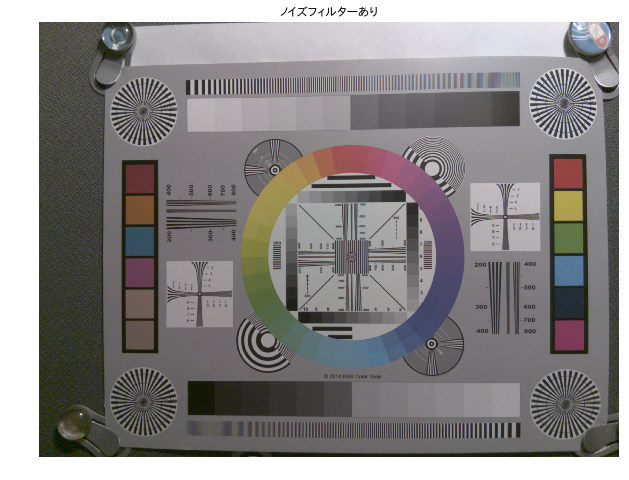

In [81]:
ccm_flt_img = color_correction_matrix(img_flt, color_matrix)
gmm_flt_img = gamma_correction(ccm_flt_img / white_level, 2.2)

# 画像表示
plt.figure(figsize=(16, 8))
plt.imshow(gmm_flt_img)
plt.axis('off')
plt.title(u"ノイズフィルターあり")
plt.show()

拡大してノイズフィルターなしの画像と比較してみましょう。

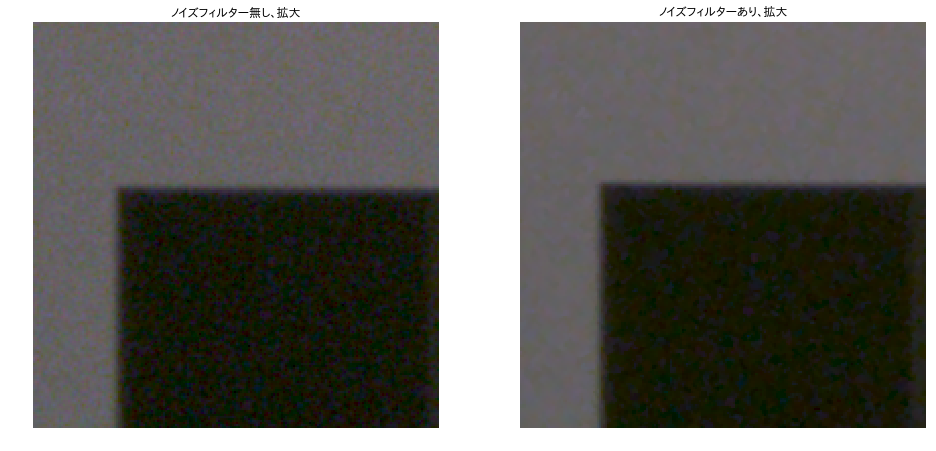

In [85]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(gmm_img[1950:2150, 800:1000, :])
plt.axis('off')
plt.title(u"ノイズフィルター無し、拡大")
plt.subplot(1, 2, 2)
plt.imshow(gmm_flt_img[1950:2150, 800:1000, :])
plt.axis('off')
plt.title(u"ノイズフィルターあり、拡大")
plt.show()

正常に処理できているようです。他の部分も見てみましょう。

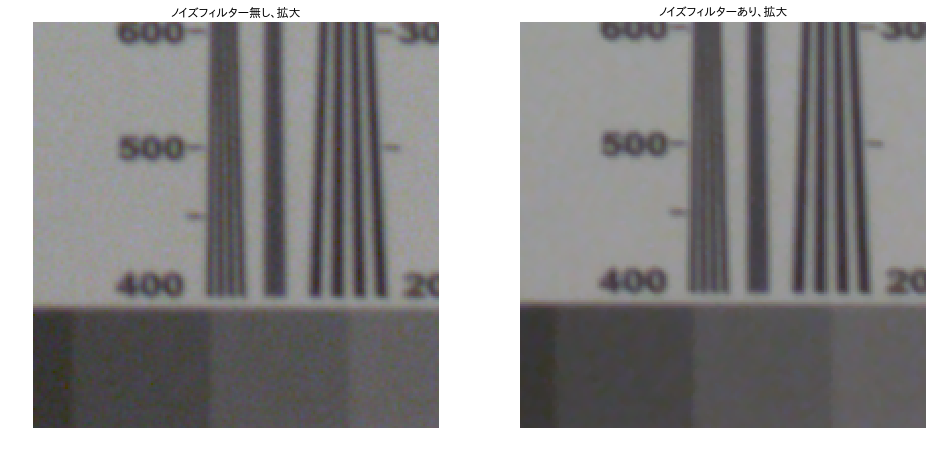

In [95]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(gmm_img[1500:1700, 1650:1850, :])
plt.axis('off')
plt.title(u"ノイズフィルター無し、拡大")
plt.subplot(1, 2, 2)
plt.imshow(gmm_flt_img[1500:1700, 1650:1850, :])
plt.axis('off')
plt.title(u"ノイズフィルターあり、拡大")
plt.show()

平坦部のノイズは減っていますが、ディテールの大部分は残っていることがわかります。

## ノイズフィルター処理の高速化

最後にもう一点だけ、処理の高速化について触れます。この項はPythonでの最適化に興味のない方は読み飛ばしてかまいません。

上記のノイズフィルターのコードはプログラムとしては動作しますが、非常に遅いコードです。

これはPythonの性能上しかたのない部分もあるのですが、numpyなどの機能を利用することでかなり改善できます。[^2]

[^2]: ただし、処理の内容が一見わかりにくくなるというトレードオフがあります。これが理由で先程はベタ書きの処理を紹介しました。

まず、一般的な傾向としてnumpyではループの処理は遅いので、なるべくforループを減らしたほうが高速になる場合が多いです。
numpyにはこのような用途のためにstride_tricksというライブラリがありますので、これを利用してループを減らしていきましょう。

まずは、RGBの平均画像(luma_img)から分散を計算します。

In [97]:
from numpy.lib.stride_tricks import as_strided
import scipy

coef = 0.1

average = scipy.ndimage.filters.uniform_filter(luma_img, 5, mode='mirror')
sigma_map = average * par[1]
sigma_map[sigma_map < 1] = 1
sy, sx = sigma_map.strides
sigma_tile = as_strided(sigma_map, strides=(sy, sx, 0, 0), shape=(h, w, 5, 5))
sigma_tile = sigma_tile[2:h-2, 2:w-2, : , :]

ここではまず、3278 x 2444 通りの5x5のパッチについて、FIRフィルターを使って平均値を計算し、そこからノイズ分散をもとめています。

次にそのノイズ分散値をコピーして同じ要素の5x5の行列を作り、その5x5の行列を3278 x 2444個並べています。

同様に、各パッチの平均値をコピーして同じ要素の5x5の行列を作り、その5x5の行列を3278 x 2444個並べます。

In [98]:
sy, sx = luma_img.strides
luma_tile = as_strided(luma_img, strides=(sy, sx, 0, 0), shape=(h, w, 5, 5))
luma_tile = luma_tile[2:h-2, 2:w-2, : , :]

次に、RGBの平均画像(luma_img)から5x5のパッチを3278 x 2444通り作ります。

In [100]:
sy, sx = luma_img.strides
luma_box = as_strided(luma_img, strides=(sy, sx, sy, sx), shape=(h-4, w-4, 5, 5))

In [101]:
diff = luma_box - luma_tile
weight = np.exp(-coef * diff * diff / sigma_tile)
weight_sum = weight.sum(axis=(2, 3))

In [102]:
red = dms_img[:, :, 0]
sy, sx = red.strides
red_boxes = as_strided(red, strides=(sy, sx, sy, sx), shape=(h-4, w-4, 5, 5))
red_out = (weight * red_boxes).sum(axis=(2, 3)) / weight_sum

In [103]:
green = dms_img[:, :, 1]
sy, sx = green.strides
green_boxes = as_strided(green, strides=(sy, sx, sy, sx), shape=(h-4, w-4, 5, 5))
green_out = (weight * green_boxes).sum(axis=(2, 3)) / weight_sum

blue = dms_img[:, :, 2]
sy, sx = blue.strides
blue_boxes = as_strided(blue, strides=(sy, sx, sy, sx), shape=(h-4, w-4, 5, 5))
blue_out = (weight * blue_boxes).sum(axis=(2, 3)) / weight_sum

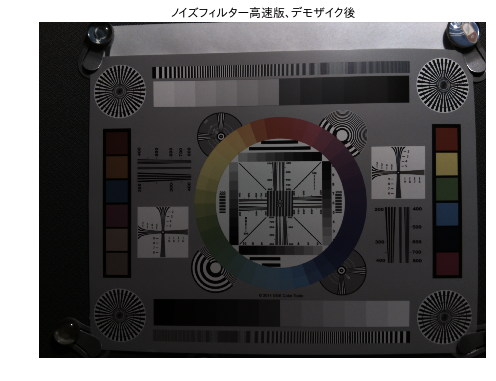

In [112]:
img_flt2 = dms_img.copy()
img_flt2[2:h-2, 2:w-2, 0] = red_out
img_flt2[2:h-2, 2:w-2, 1] = green_out
img_flt2[2:h-2, 2:w-2, 2] = blue_out

outimg = img_flt2.copy()
outimg = outimg.reshape((h, w, 3))
outimg = outimg / 1024
outimg[outimg < 0] = 0
outimg[outimg > 1] = 1
plt.figure(figsize=(8, 8))
plt.imshow(outimg)
plt.axis('off')
plt.title(u"ノイズフィルター高速版、デモザイク後")
plt.show()

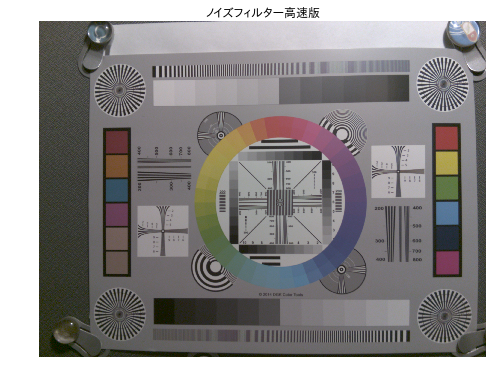

In [111]:
ccm_flt2_img = color_correction_matrix(img_flt2, color_matrix)
gmm_flt2_img = gamma_correction(ccm_flt2_img / white_level, 2.2)

# 画像表示
plt.figure(figsize=(8, 8))
plt.imshow(gmm_flt2_img)
plt.axis('off')
plt.title(u"ノイズフィルター高速版")
plt.show()

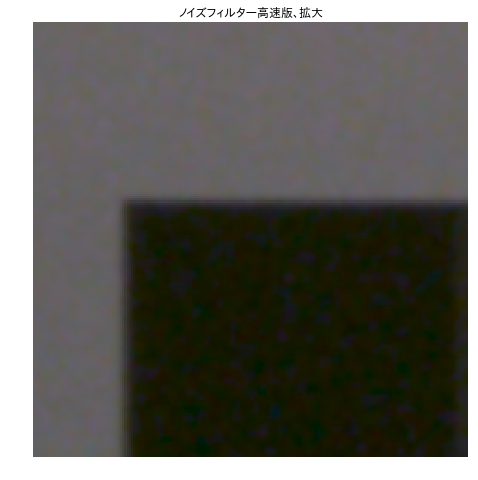

In [109]:
plt.figure(figsize=(16, 8))
plt.imshow(gmm_flt2_img[1950:2150, 800:1000, :])
plt.axis('off')
plt.title(u"ノイズフィルター高速版、拡大")
plt.show()

先ほどと同様の画像が出力されたようです。

これでノイズ処理からループが一掃されました。
処理の速度も数倍になり、実用的になりました。

## まとめ

今回はノイズフィルターをとりあげ、エッジを残すノイズフィルターとしてよく使われるバイラテラル・フィルターを解説し、実装しました。

バイラテラルフィルターは移り変わりの激しい画像処理の分野では、もはや古典的ともいえるアルゴリズムです。
アルゴリズムの発表から時間が立つとはいえその基本的な考え方は現在のノイズフィルターにも受け継がれています。

とはいえ、次々に、より高性能なノイズフィルターアルゴリズムが提案されているのは間違いなく、性能もどんどん進化しています。
今回の内容で物足りない方は、BM3D[^4]やディープラーニングを用いたノイズフィルター[^5]など、さらに現代的なノイズフィルターアルゴリズムを実装されてはいかがでしょうか。

[^4]: [http://www.cs.tut.fi/~foi/GCF-BM3D/:title]
[^5]: [https://web.stanford.edu/class/cs331b/2016/projects/zhao.pdf]

もう一つ重要な点として、画像内のノイズの解析と分散の推定を行い非常に簡単なノイズモデルを作成しました。
これは画像の素性のわかっているカメラ画像処理だからできることであり、このような処理ができる事がRAW現像の利点であるともいえます。
今回は光ショットノイズが支配的な画像でしたが、他のノイズが大きい画像の場合はまた違った処理が必要です。
たとえば高ISO画像（低照度画像）ではリードノイズが相対的に大きくなってきます。

また、最後にnumpyによる画像処理の高速化テクニックについても触れました。
画像処理としては本質的ではありませんが、実用上は重要な点です。